#### Executing this notebook depends on the Delta tables from project 1 being saved in DBFS!
In project 1, make sure to run chapters 1, 2, 3 fully to save the Delta tables.

#### Also make sure you have GraphFrames installed on the cluster!
https://spark-packages.org/package/graphframes/graphframes

(Choose the correct versions of Spark and Scala!)

In [0]:
# For visualization, also install NetworkX.
# Installing NetworkX via jar didn't work for me so here I install it via pip.
%pip install networkx

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import pyspark.sql.functions as F
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import graphframes as gf
import networkx as nx

spark.conf.set("spark.sql.shuffle.partitions", sc.defaultParallelism) #shuffle partitions for faster processing of graph algorithms

---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
<command-605912935960844> in <module>
      4 logger = logging.getLogger(__name__)
      5 
----> 6 import graphframes as gf
      7 import networkx as nx
      8 

/databricks/python_shell/dbruntime/PythonPackageImportsInstrumentation/__init__.py in import_patch(name, globals, locals, fromlist, level)
    165             # Import the desired module. If you’re seeing this while debugging a failed import,
    166             # look at preceding stack frames for relevant error information.
--> 167             original_result = python_builtin_import(name, globals, locals, fromlist, level)
    168 
    169             is_root_import = thread_local._nest_level == 1

ModuleNotFoundError: No module named 'graphframes'

In [0]:
dblp_df = spark.read.load('dbfs:/user/dblpv13/dblp_table')
author_df = spark.read.load('dbfs:/user/dblpv13/author_table')
org_df = spark.read.load('dbfs:/user/dblpv13/org_table')
venue_df = spark.read.load('dbfs:/user/dblpv13/venue_table')

logger.info(f'Read table row counts:\n\tDBLP fact table: {dblp_df.count()}\n\tAuthor table: {author_df.count()}\n\tVenue table: {venue_df.count()}\n\tOrganization table: {org_df.count()}')

INFO:__main__:Read table row counts:
	DBLP fact table: 275859
	Author table: 406699
	Venue table: 13567
	Organization table: 8882


In [0]:
def lim_print(df, lim):
    display(df.limit(lim))

### Vertices
* Needs to contain column **id**

To each DF, add the vertex type. We will have 4 types of vertices: publications, authors, organizations, venues.

In [0]:
# Add type to each df and rename column 'ID' to 'id'.
dblp_df = dblp_df.withColumn('Type', F.lit('publication')).withColumnRenamed('ID', 'id')
author_df = author_df.withColumn('Type', F.lit('author')).withColumnRenamed('ID', 'id')
org_df = org_df.withColumn('Type', F.lit('org')).withColumnRenamed('ID', 'id')
venue_df = venue_df.withColumn('Type', F.lit('venue')).withColumnRenamed('ID', 'id')

# Union the relevant columns of each df into a single df.
_vertices = (dblp_df
            .select('id', 'Type')
            .union(author_df
                   .select('id', 'Type'))
            .union(org_df
                   .select('id', 'Type'))
            .union(venue_df
                   .select('id', 'Type')))

In [0]:
lim_print(_vertices, 10)

id,Type
53e99784b7602d9701f3f5fe,publication
53e99792b7602d9701f5af35,publication
53e99792b7602d9701f5b0ed,publication
53e99792b7602d9701f5b119,publication
53e99792b7602d9701f5b140,publication
53e99792b7602d9701f5b19a,publication
53e99792b7602d9701f5b1ba,publication
53e99792b7602d9701f5b1e7,publication
53e99792b7602d9701f5b2b3,publication
53e99792b7602d9701f5b2bc,publication


### Edges
* Need to contain columns **src** and **dst**

We will have 4 kinds of relationships: 
* isAuthorOf (Author -> Publication)
* cites (Publication -> Publication)
* hosts (Venue -> Publication)
* worksFor (Author -> Organization)

#### isAuthorOf

In [0]:
# Source is exploded dblp.Authors
# Destination is dblp.id
isAuthorOf_edges = (dblp_df
                    .withColumn('src', F.explode(dblp_df.Authors))
                    .withColumnRenamed('id', 'dst')
                    .withColumn('Type', F.lit('isAuthorOf'))
                    .select('src', 'Type', 'dst'))

In [0]:
lim_print(isAuthorOf_edges, 10)

src,Type,dst
548997a5dabfae9b40134b74,isAuthorOf,53e9af0db7602d9703945b53
5607e30d45cedb3396b9156a,isAuthorOf,53e9af0db7602d9703945b53
542a67e9dabfae646d55d787,isAuthorOf,53e9af0db7602d9703945b73
5607e30d45cedb3396b91570,isAuthorOf,53e9af0db7602d9703945b73
53f434c2dabfaee2a1cd7352,isAuthorOf,53e9af0db7602d9703945b73
53f439e0dabfaeee229cb09b,isAuthorOf,53e9af0db7602d9703945b88
53f46cb6dabfaee2a1dc7f1b,isAuthorOf,53e9af0db7602d9703945b88
53f480a2dabfae963d25b1cf,isAuthorOf,53e9af0db7602d9703945b88
53f43495dabfaeb22f460a59,isAuthorOf,53e9af0db7602d9703945b93
53f644bddabfaeb8391b3a95,isAuthorOf,53e9af0db7602d9703945b93


#### cites

In [0]:
# Source is dblp.id
# Destination is exploded dblp.References
cites_edges = (dblp_df
               .withColumn('dst', F.explode(dblp_df.References))
               .withColumnRenamed('id', 'src')
               .withColumn('Type', F.lit('cites'))
               .select('src', 'Type', 'dst'))

In [0]:
lim_print(cites_edges, 10)

src,Type,dst
53e9af0db7602d9703945b53,cites,56d92947dabfae2eeece779a
53e9af0db7602d9703945b53,cites,53e9981db7602d970203e2ea
53e9af0db7602d9703945b53,cites,53e9b9e7b7602d97045e5340
53e9af0db7602d9703945b53,cites,53e9a216b7602d9702b1bc73
53e9af0db7602d9703945b53,cites,558a3a84e4b037c08755e6a1
53e9af0db7602d9703945b73,cites,53e99ad7b7602d970235b14a
53e9af0db7602d9703945b73,cites,53e9bbc2b7602d970480d3b2
53e9af0db7602d9703945b73,cites,53e99c12b7602d97024c12fe
53e9af0db7602d9703945b88,cites,53e9b195b7602d9703c1e770
53e9af0db7602d9703945b88,cites,53e99f03b7602d97027d342f


#### hosts

In [0]:
# Source is dblp.Venue
# Destination is dblp.id
hosts_edges = (dblp_df
               .withColumnRenamed('id', 'dst')
               .withColumnRenamed('Venue', 'src')
               .withColumn('Type', F.lit('hosts'))
               .select('src', 'Type', 'dst'))

In [0]:
lim_print(hosts_edges, 10)

src,Type,dst
572de199d39c4f49934b3d5c,hosts,53e99784b7602d9701f3f5fe
54825226582fc50b5e05610e,hosts,53e99792b7602d9701f5af35
53a727f720f7420be8ba3092,hosts,53e99792b7602d9701f5b0ed
0377-2217,hosts,53e99792b7602d9701f5b119
5550376d7cea80f9541873d5,hosts,53e99792b7602d9701f5b140
555036db7cea80f9541603d7,hosts,53e99792b7602d9701f5b19a
53a7310820f7420be8d1bc69,hosts,53e99792b7602d9701f5b1ba
555037837cea80f95418b43e,hosts,53e99792b7602d9701f5b1e7
555037227cea80f95417540f,hosts,53e99792b7602d9701f5b2b3
53907df520f770854f6106bd,hosts,53e99792b7602d9701f5b2bc


#### worksFor

In [0]:
# Source is the first author of each publication
# Destination is the org of that publication
worksFor_edges = (dblp_df
                  .withColumn('src', dblp_df.Authors.getItem(0))
                  .withColumnRenamed('Org', 'dst')
                  .withColumn('Type', F.lit('worksFor'))
                  .select('src', 'Type', 'dst'))

In [0]:
lim_print(worksFor_edges, 10)

src,Type,dst
53f46a22dabfaee0d9c3d5e5,worksFor,5f71b2e91c455f439fe3f23f
53f43a51dabfaec22baa659b,worksFor,5f71b2bd1c455f439fe3dea6
542a6734dabfae646d55cc87,worksFor,5f71b6101c455f439fe555a5
5630ff9645cedb3399c3ca55,worksFor,5f71b29c1c455f439fe3d0d7
56017d4445cedb3395e638f7,worksFor,5f71b2f61c455f439fe3f847
54301e81dabfaeca69bca10d,worksFor,5f71b2841c455f439fe3c6c8
53f42c98dabfaeb22f3fc92d,worksFor,5f71b57c1c455f439fe515f1
53f43685dabfaec09f17df79,worksFor,5f71b4501c455f439fe491ff
53f427b6dabfaec09f0d9c8a,worksFor,5f71b2961c455f439fe3ce44
54096bf9dabfae8faa68e261,worksFor,5f71b2aa1c455f439fe3d5c6


Let's combine the edges into one DF.

In [0]:
_edges = isAuthorOf_edges.union(cites_edges).union(hosts_edges).union(worksFor_edges)

In [0]:
lim_print(_edges, 10)

src,Type,dst
548997a5dabfae9b40134b74,isAuthorOf,53e9af0db7602d9703945b53
5607e30d45cedb3396b9156a,isAuthorOf,53e9af0db7602d9703945b53
542a67e9dabfae646d55d787,isAuthorOf,53e9af0db7602d9703945b73
5607e30d45cedb3396b91570,isAuthorOf,53e9af0db7602d9703945b73
53f434c2dabfaee2a1cd7352,isAuthorOf,53e9af0db7602d9703945b73
53f439e0dabfaeee229cb09b,isAuthorOf,53e9af0db7602d9703945b88
53f46cb6dabfaee2a1dc7f1b,isAuthorOf,53e9af0db7602d9703945b88
53f480a2dabfae963d25b1cf,isAuthorOf,53e9af0db7602d9703945b88
53f43495dabfaeb22f460a59,isAuthorOf,53e9af0db7602d9703945b93
53f644bddabfaeb8391b3a95,isAuthorOf,53e9af0db7602d9703945b93


### Build the GraphFrame

In [0]:
_graph = gf.GraphFrame(_vertices, _edges)

### Queries (Motif-finding)

Co-authorship network of an author. Given an Author's id, find all of the authors they have published some work with.

TODO: color nodes according to schema.

In [0]:
net = (_graph
       .filterEdges('Type = "isAuthorOf"')
       .find('(a)-[e1]->(b); (c)-[e2]->(b)')
       .filter('a.id == "542a67e9dabfae646d55d787" and c.id != a.id')) # Put the author ID here

In [0]:
display(net)

a,e1,b,c,e2
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e9ae17b7602d9703828bb5)","List(53e9ae17b7602d9703828bb5, publication)","List(542a78e3dabfae646d566d26, author)","List(542a78e3dabfae646d566d26, isAuthorOf, 53e9ae17b7602d9703828bb5)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e9b116b7602d9703b97969)","List(53e9b116b7602d9703b97969, publication)","List(542a78e3dabfae646d566d26, author)","List(542a78e3dabfae646d566d26, isAuthorOf, 53e9b116b7602d9703b97969)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e9b0ccb7602d9703b46aad)","List(53e9b0ccb7602d9703b46aad, publication)","List(542a78e3dabfae646d566d26, author)","List(542a78e3dabfae646d566d26, isAuthorOf, 53e9b0ccb7602d9703b46aad)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e9b0ccb7602d9703b46aad)","List(53e9b0ccb7602d9703b46aad, publication)","List(53f42ef3dabfaee02ac74f9d, author)","List(53f42ef3dabfaee02ac74f9d, isAuthorOf, 53e9b0ccb7602d9703b46aad)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e9ad77b7602d9703766b32)","List(53e9ad77b7602d9703766b32, publication)","List(53f4a77ddabfaedce5636c81, author)","List(53f4a77ddabfaedce5636c81, isAuthorOf, 53e9ad77b7602d9703766b32)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e99a0fb7602d9702263284)","List(53e99a0fb7602d9702263284, publication)","List(53f434c2dabfaee2a1cd7352, author)","List(53f434c2dabfaee2a1cd7352, isAuthorOf, 53e99a0fb7602d9702263284)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e9af0db7602d9703945b73)","List(53e9af0db7602d9703945b73, publication)","List(53f434c2dabfaee2a1cd7352, author)","List(53f434c2dabfaee2a1cd7352, isAuthorOf, 53e9af0db7602d9703945b73)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e9ad77b7602d9703766b32)","List(53e9ad77b7602d9703766b32, publication)","List(53f434c2dabfaee2a1cd7352, author)","List(53f434c2dabfaee2a1cd7352, isAuthorOf, 53e9ad77b7602d9703766b32)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e9ae17b7602d9703828bb5)","List(53e9ae17b7602d9703828bb5, publication)","List(56cb18b6c35f4f3c6565d10f, author)","List(56cb18b6c35f4f3c6565d10f, isAuthorOf, 53e9ae17b7602d9703828bb5)"
"List(542a67e9dabfae646d55d787, author)","List(542a67e9dabfae646d55d787, isAuthorOf, 53e9b116b7602d9703b97969)","List(53e9b116b7602d9703b97969, publication)","List(56cb18b6c35f4f3c6565d10f, author)","List(56cb18b6c35f4f3c6565d10f, isAuthorOf, 53e9b116b7602d9703b97969)"


In [0]:
# Based on https://stackoverflow.com/a/57784880

def plot_graph(df, edge_colnames, emphasize_nodes = None):
    """ Inputs: 
            df - DataFrame of the graph you want to plot 
            edge_colnames - iterable of df column names that hold the edges of the graph
            emphasize_nodes - iterable of node ids we want to color red
    """
    df_pandas = df.toPandas()
    g = nx.DiGraph()
    
    # Iterate over the columns and rows.
    # From each row, add an edge with the src and dst.
    for colname in edge_colnames:
        for row in df_pandas[colname]:
            g.add_edge(row['src'], row['dst'])
    
    if emphasize_nodes:
        color_map = ['red' if node in emphasize_nodes else 'blue' for node in g]
            
    nx.draw(g, node_color=color_map)

**Legend for visualizations:**
* Red - publications
* Purple - venues
* Blue - authors
* Green - organizations
* Yellow - special vertex (vertex that the query started from)

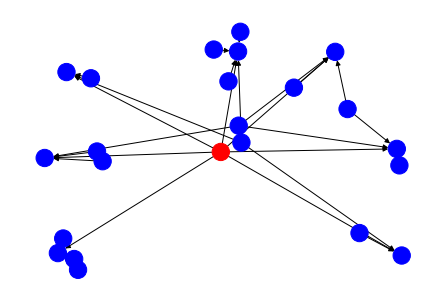

In [0]:
plot_graph(net, ('e1', 'e2'), ('542a67e9dabfae646d55d787'))

Given an org ID, which authors work for that org. - Martin

Given a publication ID, what organizations have the authors of this publication worked for. - Peep

In [0]:
net = (_graph
       .filterEdges('Type = "isAuthorOf" | Type = worksFor')
       #.find('(a)-[e1]->(b); (c)-[e2]->(b)')
       #.filter('a.id == "542a67e9dabfae646d55d787" and c.id != a.id')) # Put the author ID here
      )

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-1509400414693873> in <module>
----> 1 net = (_graph
      2        .filterEdges('Type = "isAuthorOf" | Type = worksFor')
      3        #.find('(a)-[e1]->(b); (c)-[e2]->(b)')
      4        #.filter('a.id == "542a67e9dabfae646d55d787" and c.id != a.id')) # Put the author ID here
      5       )

NameError: name '_graph' is not defined

Given a Venue ID, find all authors who have been hosted by that venue. - Martin

### Analytics

PageRank - P

connected components - M

bfs between two publications: returns a path from one node to another. To find out if a publication indirectly references another publication. -P

in-degrees of a publication. How many authors this publication has. -M

out-degrees of a venue. How many publications has a venue hosted. -P

traingle count -M

triplets -P